<a href="https://colab.research.google.com/github/kashperova/ssl-iasa/blob/fix%2Fnoisy-student-trainer/notebooks/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/kashperova/ssl-iasa.git

Cloning into 'ssl-iasa'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 161 (delta 73), reused 123 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (161/161), 65.24 KiB | 4.35 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [3]:
%ls

gdrive/  sample_data/  ssl-iasa/


In [4]:
%cd ssl-iasa/src

/content/ssl-iasa/src


In [5]:
from utils.seed import SeedSetter

seed: int = 42
SeedSetter(seed)

Random seed set to 42


In [6]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
from datasets.loader import DatasetLoader

DATASET: str = "OxfordIIITPet"
dataset = DatasetLoader(name=DATASET, transform=transform).load()

100%|██████████| 791918971/791918971 [00:03<00:00, 246090096.60it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 109497820.39it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


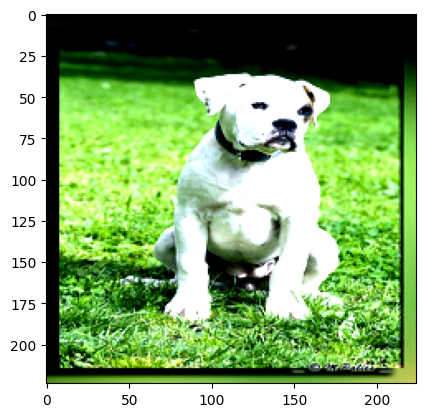

In [9]:
from utils.plots import plot_image

image, label = dataset[70]
plot_image(image)

In [8]:
num_classes = len(dataset.classes)
num_classes

37

In [10]:
from models.vgg16 import VGG16

model = VGG16(num_classes=num_classes, st_depth_prob=0.0)

In [9]:
from datasets.unlabeled import UnlabeledDataset
from torch.utils.data import random_split

total_size = len(dataset)
labeled_size = int(0.3 * total_size)
unlabeled_size = total_size - labeled_size

labeled_dataset, data_for_ssl = random_split(dataset, [labeled_size, unlabeled_size])
unlabeled_dataset = UnlabeledDataset(data_for_ssl)

In [10]:
!pip install torchmetrics==1.4.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 34.8 MB/s eta 0:00:00


In [19]:
from config.train_config import BaseTrainConfig
from trainers.supervised.base import BaseSupervisedTrainer
from utils.metrics import Metrics, Task
from torch import nn, optim


class Train1Config(BaseTrainConfig):
    epochs: int = 8
    train_batch_size: int = 32
    eval_batch_size: int = 64
    train_test_split: float = 0.7

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1, min_lr=1e-6)
metrics = Metrics(task=Task.MULTICLASS_CLASSIFICATION, average="macro", num_classes=num_classes)
criterion = nn.CrossEntropyLoss()

trainer = BaseSupervisedTrainer(
    model=model,
    loss_fn=criterion,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    dataset=dataset,
    config=Train1Config(),
    metrics=metrics,
    save_dir="/content/gdrive/MyDrive/ssl-iasa/lab1/base"
)

In [20]:
base_best_model = trainer.train(verbose=True)

Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/8], Train Loss: 2.7025, Valid Loss: 1.0584

Training metrics: 
Accuracy: 0.2628
Recall: 0.2622
Precision: 0.2774
F1: 0.2577


Validation metrics: 
Accuracy: 0.731
Recall: 0.7299
Precision: 0.7515
F1: 0.7211



Training:  12%|█▎        | 1/8 [01:02<07:18, 62.59s/it]

Epoch [2/8], Train Loss: 1.0044, Valid Loss: 0.6905

Training metrics: 
Accuracy: 0.6941
Recall: 0.6941
Precision: 0.6925
F1: 0.6921


Validation metrics: 
Accuracy: 0.7862
Recall: 0.7909
Precision: 0.8254
F1: 0.7807



Training:  25%|██▌       | 2/8 [02:04<06:13, 62.33s/it]

Epoch [3/8], Train Loss: 0.5876, Valid Loss: 0.5504

Training metrics: 
Accuracy: 0.8207
Recall: 0.8198
Precision: 0.8212
F1: 0.8199


Validation metrics: 
Accuracy: 0.8424
Recall: 0.8482
Precision: 0.8542
F1: 0.836



Training:  38%|███▊      | 3/8 [03:06<05:10, 62.15s/it]

Epoch [4/8], Train Loss: 0.3842, Valid Loss: 0.4703

Training metrics: 
Accuracy: 0.8816
Recall: 0.882
Precision: 0.8827
F1: 0.8819


Validation metrics: 
Accuracy: 0.8641
Recall: 0.8666
Precision: 0.8727
F1: 0.8619



Training:  62%|██████▎   | 5/8 [05:09<03:04, 61.51s/it]

Epoch [5/8], Train Loss: 0.2695, Valid Loss: 0.5134

Training metrics: 
Accuracy: 0.9212
Recall: 0.9206
Precision: 0.9213
F1: 0.9208


Validation metrics: 
Accuracy: 0.8487
Recall: 0.8521
Precision: 0.8634
F1: 0.8479



Training:  75%|███████▌  | 6/8 [06:09<02:01, 60.99s/it]

Epoch [6/8], Train Loss: 0.1993, Valid Loss: 0.5368

Training metrics: 
Accuracy: 0.934
Recall: 0.934
Precision: 0.9344
F1: 0.9341


Validation metrics: 
Accuracy: 0.8542
Recall: 0.8573
Precision: 0.8674
F1: 0.8521



Training:  88%|████████▊ | 7/8 [07:09<01:00, 60.66s/it]

Epoch [7/8], Train Loss: 0.0840, Valid Loss: 0.4874

Training metrics: 
Accuracy: 0.9728
Recall: 0.9727
Precision: 0.9733
F1: 0.9729


Validation metrics: 
Accuracy: 0.875
Recall: 0.8785
Precision: 0.875
F1: 0.8734



Training: 100%|██████████| 8/8 [08:08<00:00, 61.12s/it]

Epoch [8/8], Train Loss: 0.0698, Valid Loss: 0.5028

Training metrics: 
Accuracy: 0.9771
Recall: 0.9768
Precision: 0.9778
F1: 0.9771


Validation metrics: 
Accuracy: 0.8768
Recall: 0.8796
Precision: 0.8776
F1: 0.8749




/content/ssl-iasa/src/trainers/supervised/base.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(os.path.join(self.save_dir, f'{se

In [21]:
trainer.plot_losses()

In [11]:
from config.train_config import BaseTrainConfig
from trainers.self_learning.noisy_student import NoisyStudentTrainer
from models.vgg16 import VGG16
from utils.metrics import Metrics, Task
from torch import nn, optim
from torchvision.transforms import RandAugment


class TeacherConfig(BaseTrainConfig):
    epochs: int = 10
    train_batch_size: int = 32
    eval_batch_size: int = 64
    train_test_split: float = 0.75

class StudentConfig(BaseTrainConfig):
    epochs: int = 8
    train_batch_size: int = 32
    eval_batch_size: int = 64
    train_test_split: float = 0.75


student_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

teacher_model = VGG16(num_classes=num_classes, dropout=0.2)
student_model = VGG16(num_classes=num_classes, dropout=0.5)

teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=0.01, momentum=0.9)
teacher_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(teacher_optimizer, mode='min', factor=0.2, patience=1, min_lr=1e-6)

student_optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9)
student_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(student_optimizer, mode='min', factor=0.2, patience=1, min_lr=1e-6)

metrics = Metrics(task=Task.MULTICLASS_CLASSIFICATION, average="macro", num_classes=num_classes)
criterion = nn.CrossEntropyLoss()

ns_trainer = NoisyStudentTrainer(
    teacher_model=teacher_model,
    student_model=student_model,
    loss_fn=criterion,
    teacher_optimizer=teacher_optimizer,
    student_optimizer=student_optimizer,
    labeled_dataset=labeled_dataset,
    unlabeled_dataset=unlabeled_dataset,
    teacher_lr_scheduler=teacher_lr_scheduler,
    student_lr_scheduler=student_lr_scheduler,
    teacher_config=TeacherConfig(),
    student_config=StudentConfig(),
    student_transform=student_transform,
    metrics=metrics,
    save_dir="/content/gdrive/MyDrive/ssl-iasa/lab1/noisy_student"
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 204MB/s]


In [14]:
teacher_best_model = ns_trainer.train_teacher(verbose=True)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 3.5359, Valid Loss: 3.2613

Training metrics: 
Accuracy: 0.0773
Recall: 0.0694
Precision: 0.0705
F1: 0.0591


Validation metrics: 
Accuracy: 0.2319
Recall: 0.2338
Precision: 0.1957
F1: 0.1559



Training:  10%|█         | 1/10 [00:36<05:26, 36.27s/it]

Epoch [2/10], Train Loss: 2.5305, Valid Loss: 1.7538

Training metrics: 
Accuracy: 0.3744
Recall: 0.331
Precision: 0.4816
F1: 0.2963


Validation metrics: 
Accuracy: 0.5362
Recall: 0.5019
Precision: 0.5455
F1: 0.4532



Training:  20%|██        | 2/10 [00:55<03:30, 26.31s/it]

Epoch [3/10], Train Loss: 1.2964, Valid Loss: 1.2423

Training metrics: 
Accuracy: 0.6292
Recall: 0.6207
Precision: 0.6361
F1: 0.6213


Validation metrics: 
Accuracy: 0.6775
Recall: 0.6833
Precision: 0.706
F1: 0.6506



Training:  30%|███       | 3/10 [01:14<02:42, 23.15s/it]

Epoch [4/10], Train Loss: 0.8374, Valid Loss: 0.9496

Training metrics: 
Accuracy: 0.7428
Recall: 0.736
Precision: 0.7491
F1: 0.7391


Validation metrics: 
Accuracy: 0.6993
Recall: 0.6819
Precision: 0.738
F1: 0.6615



Training:  50%|█████     | 5/10 [01:53<01:42, 20.53s/it]

Epoch [5/10], Train Loss: 0.5377, Valid Loss: 1.0044

Training metrics: 
Accuracy: 0.8237
Recall: 0.8258
Precision: 0.8317
F1: 0.8263


Validation metrics: 
Accuracy: 0.6884
Recall: 0.6751
Precision: 0.7592
F1: 0.6659

Epoch [6/10], Train Loss: 0.3527, Valid Loss: 0.8340

Training metrics: 
Accuracy: 0.9046
Recall: 0.9008
Precision: 0.909
F1: 0.9032


Validation metrics: 
Accuracy: 0.7428
Recall: 0.727
Precision: 0.7443
F1: 0.7097



Training:  70%|███████   | 7/10 [02:31<00:59, 19.70s/it]

Epoch [7/10], Train Loss: 0.2350, Valid Loss: 0.8387

Training metrics: 
Accuracy: 0.9227
Recall: 0.9204
Precision: 0.9225
F1: 0.9205


Validation metrics: 
Accuracy: 0.7428
Recall: 0.7452
Precision: 0.7849
F1: 0.7265



Training:  80%|████████  | 8/10 [02:50<00:38, 19.40s/it]

Epoch [8/10], Train Loss: 0.1427, Valid Loss: 0.8673

Training metrics: 
Accuracy: 0.9553
Recall: 0.9555
Precision: 0.9556
F1: 0.9544


Validation metrics: 
Accuracy: 0.7391
Recall: 0.7313
Precision: 0.7687
F1: 0.7132

Epoch [9/10], Train Loss: 0.1139, Valid Loss: 0.7231

Training metrics: 
Accuracy: 0.9698
Recall: 0.9692
Precision: 0.9715
F1: 0.9697


Validation metrics: 
Accuracy: 0.7754
Recall: 0.769
Precision: 0.7967
F1: 0.7549



Training: 100%|██████████| 10/10 [03:29<00:00, 20.94s/it]

Epoch [10/10], Train Loss: 0.0629, Valid Loss: 0.7491

Training metrics: 
Accuracy: 0.9867
Recall: 0.9866
Precision: 0.9874
F1: 0.9868


Validation metrics: 
Accuracy: 0.7971
Recall: 0.7973
Precision: 0.8019
F1: 0.781




/content/ssl-iasa/src/trainers/supervised/base.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(os.path.join(self.save_dir, f'{se

In [15]:
ns_trainer.plot_teacher_losses()

In [ ]:
student_best_model = ns_trainer.train_student(verbose=True)

Pseudo Label Annotation


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/8], Train Loss: 2.6018, Valid Loss: 1.0476

Training metrics: 
Accuracy: 0.2986
Recall: 0.2885
Precision: 0.3312
F1: 0.2891


Validation metrics: 
Accuracy: 0.7152
Recall: 0.7233
Precision: 0.7631
F1: 0.705



Training:  12%|█▎        | 1/8 [01:01<07:10, 61.49s/it]

Epoch [2/8], Train Loss: 0.9405, Valid Loss: 0.6349

Training metrics: 
Accuracy: 0.7014
Recall: 0.694
Precision: 0.6977
F1: 0.6945


Validation metrics: 
Accuracy: 0.7946
Recall: 0.7883
Precision: 0.8305
F1: 0.7787



Training:  25%|██▌       | 2/8 [01:45<05:07, 51.21s/it]

Epoch [3/8], Train Loss: 0.5795, Valid Loss: 0.5809

Training metrics: 
Accuracy: 0.8083
Recall: 0.8043
Precision: 0.8063
F1: 0.8047


Validation metrics: 
Accuracy: 0.8152
Recall: 0.8123
Precision: 0.8378
F1: 0.803



Training:  38%|███▊      | 3/8 [02:29<04:00, 48.05s/it]

Epoch [4/8], Train Loss: 0.3827, Valid Loss: 0.4745

Training metrics: 
Accuracy: 0.8772
Recall: 0.8715
Precision: 0.8743
F1: 0.8723


Validation metrics: 
Accuracy: 0.8424
Recall: 0.8422
Precision: 0.8554
F1: 0.8381



Training:  62%|██████▎   | 5/8 [03:57<02:16, 45.39s/it]

Epoch [5/8], Train Loss: 0.2706, Valid Loss: 0.5745

Training metrics: 
Accuracy: 0.9109
Recall: 0.9083
Precision: 0.9096
F1: 0.9088


Validation metrics: 
Accuracy: 0.8239
Recall: 0.8224
Precision: 0.8399
F1: 0.8146



Training:  75%|███████▌  | 6/8 [04:40<01:29, 44.77s/it]

Epoch [6/8], Train Loss: 0.2066, Valid Loss: 0.6688

Training metrics: 
Accuracy: 0.9351
Recall: 0.9336
Precision: 0.934
F1: 0.9336


Validation metrics: 
Accuracy: 0.8315
Recall: 0.8358
Precision: 0.8554
F1: 0.8282



In [14]:
ns_trainer.plot_student_losses()

In [15]:
ns_trainer.student_trainer.eval()


Validation metrics: 
Accuracy: 0.8424
Recall: 0.8422
Precision: 0.8554
F1: 0.8381

